# BOPS Case study

Cargamos la información

In [1]:
import pandas as pd
from datetime import datetime
from fbprophet import Prophet
data_folder='C:/Users/ylove/Documents/Diego/examen_DS_bbva/examen_DS_bbva/data'

bops_bm_df = pd.read_csv(data_folder+'/bops/bops_bm.csv')
bops_ol_df = pd.read_csv(data_folder+'/bops/bops_online.csv')

bops = {
    'bm': bops_bm_df,
    'ol': bops_ol_df
}

s_type = ('bm', 'ol')

In [2]:
for kind in s_type:
    display(bops[kind].head(5))

,id (store),year,month,week,usa,after,sales,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,1.0,2011.0,4.0,16.0,0.0,0.0,"118,691",NaN,NaN,NaN,NaN
1,1.0,2011.0,4.0,17.0,0.0,0.0,"113,804",NaN,NaN,NaN,NaN
2,1.0,2011.0,4.0,18.0,0.0,0.0,"172,104",NaN,NaN,NaN,NaN
3,1.0,2011.0,5.0,19.0,0.0,0.0,"105,591",NaN,NaN,NaN,NaN
4,1.0,2011.0,5.0,20.0,0.0,0.0,"94,884",NaN,NaN,NaN,NaN


,id (DMA),year,month,week,after,close,sales,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1,2011,4,17,0,1,"18,564",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2011,4,18,0,1,"30,883",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2011,5,19,0,1,"37,425",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2011,5,20,0,1,"32,563",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2011,5,21,0,1,"35,773",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preprocessing

In [3]:
#Drop columns that are Unnamed
for kind in s_type:
    [bops[kind].drop(colname, axis=1, inplace=True) for colname in bops[kind].columns if 'Unnamed' in colname]

#Change the name of the columns for analysis    
for kind in s_type:
    bops[kind].dropna(inplace=True)
    bops[kind].rename(columns={' sales ': 'sales','id (store)': 'id','id (DMA)': 'id'},inplace=True)

#Create a date time index for the pricing analysis
for kind in s_type:
    bops[kind]['date'] = bops[kind].apply(lambda x:datetime.strptime(
        '{:d}-{:d}-1'.format(int(x.year), int(x.week)),"%Y-%W-%w"),axis=1)

    bops[kind].set_index('date', inplace=True)
    bops[kind].sort_index(inplace=True)
    bops[kind]['sales'] = bops[kind]['sales'].str.replace(',', '').astype('float64')

In [4]:
for kind in s_type:
    display(bops[kind].head(5))

,id,year,month,week,usa,after,sales
date,,,,,,,
2011-04-18,1.0,2011.0,4.0,16.0,0.0,0.0,118691.0
2011-04-18,125.0,2011.0,4.0,16.0,1.0,0.0,124699.0
2011-04-18,15.0,2011.0,4.0,16.0,1.0,0.0,72407.0
2011-04-18,123.0,2011.0,4.0,16.0,1.0,0.0,76182.0
2011-04-18,121.0,2011.0,4.0,16.0,1.0,0.0,49854.0


,id,year,month,week,after,close,sales
date,,,,,,,
2011-04-25,1,2011,4,17,0,1,18564.0
2011-04-25,78,2011,4,17,0,0,502.0
2011-04-25,26,2011,4,17,0,0,34557.0
2011-04-25,92,2011,4,17,0,0,18612.0
2011-04-25,87,2011,4,17,0,0,20513.0


Graficamos los problemas de antes y despues BOPS

In [5]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

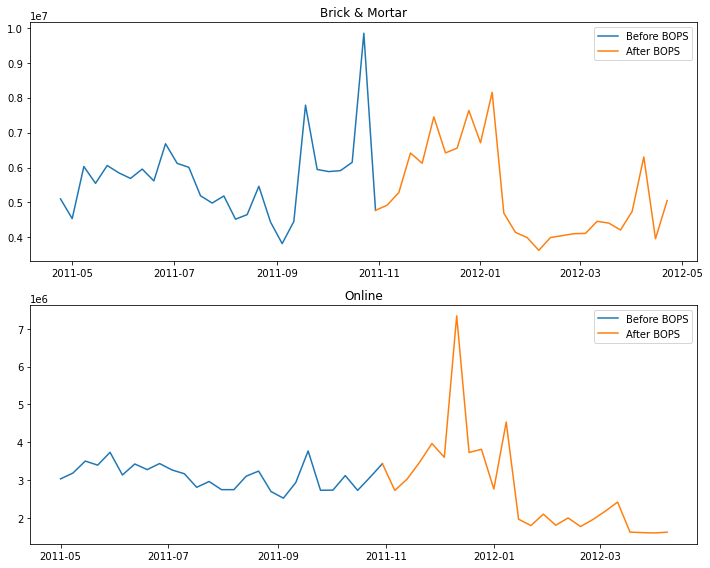

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(
    pd.concat(
        [
            bops_bm_df[bops_bm_df["after"] == 0]["sales"].resample("w").sum(),
            bops_bm_df[bops_bm_df["after"] == 1]["sales"].resample("w").sum().head(1),
        ]
    ),
    label="Before BOPS",
)

axs[0].plot(
    bops_bm_df[bops_bm_df["after"] == 1]["sales"].resample("w").sum(),
    label="After BOPS",
)
axs[1].plot(
    pd.concat(
        [
            bops_ol_df[bops_ol_df["after"] == 0]["sales"].resample("w").sum(),
            bops_ol_df[bops_ol_df["after"] == 1]["sales"].resample("w").sum().head(1),
        ]
    ),
    label="Before BOPS",
)

axs[1].plot(
    bops_ol_df[bops_ol_df["after"] == 1]["sales"].resample("w").sum(),
    label="After BOPS",
)
axs[0].set_title("Brick & Mortar")
axs[1].set_title("Online")
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()
plt.close()


Vemos algo de estacionalidad vamos a revisar los casos de Canadá y las tiendas cercanas

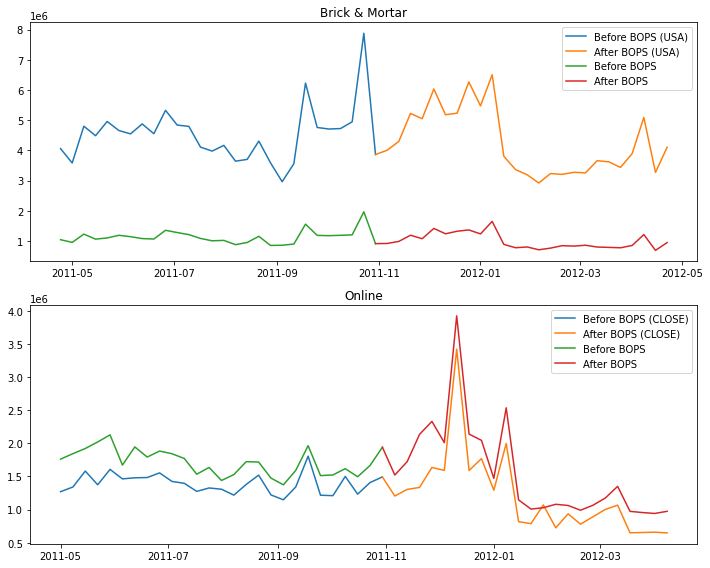

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(
    pd.concat(
        [
            bops_bm_df[(bops_bm_df["after"] == 0) & (bops_bm_df["usa"] == 1)]["sales"]
            .resample("w")
            .sum(),
            bops_bm_df[(bops_bm_df["after"] == 1) & (bops_bm_df["usa"] == 1)]["sales"]
            .resample("w")
            .sum()
            .head(1),
        ]
    ),
    label="Before BOPS (USA)",
)

axs[0].plot(
    bops_bm_df[(bops_bm_df["after"] == 1) & (bops_bm_df["usa"] == 1)]["sales"]
    .resample("w")
    .sum(),
    label="After BOPS (USA)",
)

axs[0].plot(
    pd.concat(
        [
            bops_bm_df[(bops_bm_df["after"] == 0) & (bops_bm_df["usa"] == 0)]["sales"]
            .resample("w")
            .sum(),
            bops_bm_df[(bops_bm_df["after"] == 1) & (bops_bm_df["usa"] == 0)]["sales"]
            .resample("w")
            .sum()
            .head(1),
        ]
    ),
    label="Before BOPS",
)

axs[0].plot(
    bops_bm_df[(bops_bm_df["after"] == 1) & (bops_bm_df["usa"] == 0)]["sales"]
    .resample("w")
    .sum(),
    label="After BOPS",
)


axs[1].plot(
    pd.concat(
        [
            bops_ol_df[(bops_ol_df["after"] == 0) & (bops_ol_df["close"] == 1)]["sales"]
            .resample("w")
            .sum(),
            bops_ol_df[(bops_ol_df["after"] == 1) & (bops_ol_df["close"] == 1)]["sales"]
            .resample("w")
            .sum()
            .head(1),
        ]
    ),
    label="Before BOPS (CLOSE)",
)


axs[1].plot(
    bops_ol_df[(bops_ol_df["after"] == 1) & (bops_ol_df["close"] == 1)]["sales"]
    .resample("w")
    .sum(),
    label="After BOPS (CLOSE)",
)
axs[1].plot(
    pd.concat(
        [
            bops_ol_df[(bops_ol_df["after"] == 0) & (bops_ol_df["close"] == 0)]["sales"]
            .resample("w")
            .sum(),
            bops_ol_df[(bops_ol_df["after"] == 1) & (bops_ol_df["close"] == 0)]["sales"]
            .resample("w")
            .sum()
            .head(1),
        ]
    ),
    label="Before BOPS",
)


axs[1].plot(
    bops_ol_df[(bops_ol_df["after"] == 1) & (bops_ol_df["close"] == 0)]["sales"]
    .resample("w")
    .sum(),
    label="After BOPS",
)
axs[0].set_title("Brick & Mortar")
axs[1].set_title("Online")
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()
plt.close()


Hcemos algunas proyecciones con Prophet

In [8]:
ph_ol_df = (
    pd.DataFrame(
        bops_ol_df[bops_ol_df["close"] == 0]["sales"].resample("w").sum(),
    )
    .reset_index()
    .rename(columns={"date": "ds", "sales": "y"})
)

ph_ol_close_df = (
    pd.DataFrame(
        bops_ol_df[bops_ol_df["close"] == 1]["sales"].resample("w").sum(),
    )
    .reset_index()
    .rename(columns={"date": "ds", "sales": "y"})
)

ph_bm_df = (
    pd.DataFrame(
        bops_bm_df[bops_bm_df["usa"] == 0]["sales"].resample("w").sum(),
    )
    .reset_index()
    .rename(columns={"date": "ds", "sales": "y"})
)

ph_bm_usa_df = (
    pd.DataFrame(
        bops_bm_df[bops_bm_df["usa"] == 1]["sales"].resample("w").sum(),
    )
    .reset_index()
    .rename(columns={"date": "ds", "sales": "y"})
)


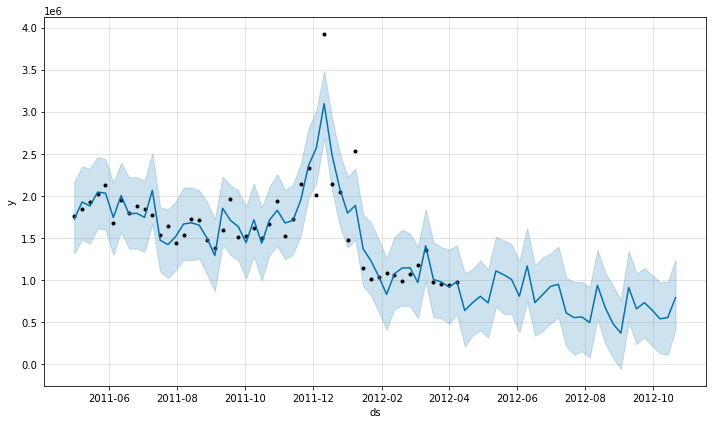

In [9]:
m = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=2,
)

m.add_seasonality(name="monthly", period=30.5, fourier_order=5, prior_scale=0.02)

m.fit(ph_ol_df)

future = m.make_future_dataframe(
    periods=28,
    freq="W",
)

forecast_ol = m.predict(future)

m.plot(forecast_ol);

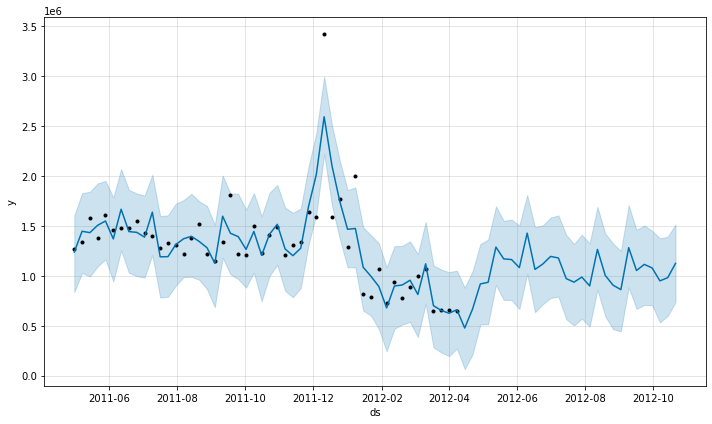

In [10]:
m = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=2
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

m.fit(ph_ol_close_df)

future = m.make_future_dataframe(
        periods=28,
        freq='W',
)

forecast_ol_close = m.predict(future)

m.plot(forecast_ol_close);

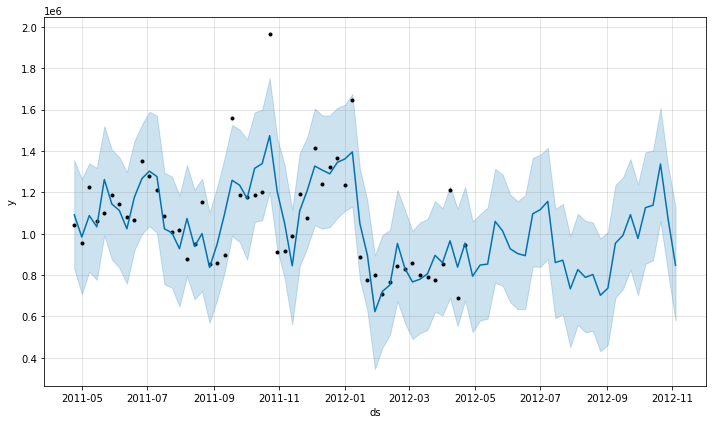

In [11]:
m = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=2
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

m.fit(ph_bm_df)

future = m.make_future_dataframe(
        periods=28,
        freq='W',
)

forecast_bm = m.predict(future)

m.plot(forecast_bm);

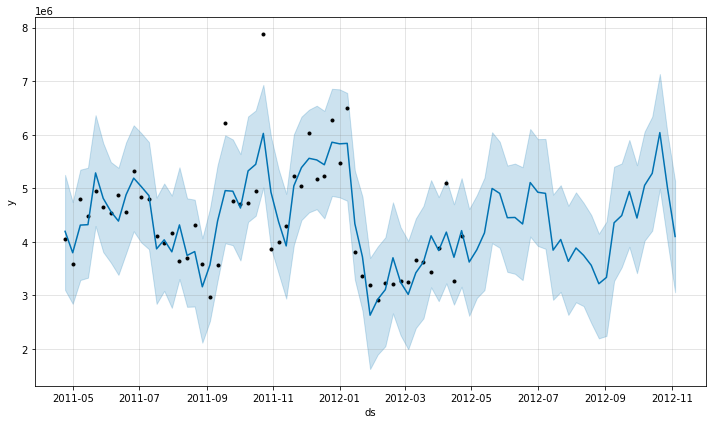

In [12]:
m = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=2,
)

m.add_seasonality(name="monthly", period=30.5, fourier_order=5, prior_scale=0.02)

m.fit(ph_bm_usa_df)

future = m.make_future_dataframe(
    periods=28,
    freq="W",
)

forecast_bm_usa = m.predict(future)

m.plot(forecast_bm_usa);


Proyectamos con base en las estimaciones

In [13]:
shifted_ph_ol = ph_ol_df.set_index('ds').shift(366, freq='d')
shifted_ph_ol_close = ph_ol_close_df.set_index('ds').shift(366, freq='d')
shifted_ph_bm = ph_bm_df.set_index('ds').shift(366, freq='d')
shifted_ph_bm_usa = ph_bm_usa_df.set_index('ds').shift(366, freq='d')

In [14]:
display(
    "Online: {}".format(
        shifted_ph_ol[shifted_ph_ol.index <= "2012-11-04"]["y"].sum()
        - forecast_ol["yhat"].sum()
    )
)
display(
    "Online close: {}".format(
        shifted_ph_ol_close[shifted_ph_ol_close.index <= "2012-11-04"]["y"].sum()
        - forecast_ol_close["yhat"].sum()
    )
)
display(
    "BM: {}".format(
        shifted_ph_bm[shifted_ph_bm.index <= "2012-11-04"]["y"].sum()
        - forecast_bm["yhat"].sum()
    )
)
display(
    "BM USA: {}".format(
        shifted_ph_bm_usa[shifted_ph_bm_usa.index <= "2012-11-04"]["y"].sum()
        - forecast_bm_usa["yhat"].sum()
    )
)


'Online: -56502472.912058085'

'Online close: -56938372.544747874'

'BM: -51461650.30232999'

'BM USA: -229294095.0444125'

Por lo ue no es buena idea extender el problema